In [ ]:
%load_ext blackcellmagic

In [ ]:
import requests
import re
import time
from gget import *
from bs4 import BeautifulSoup
from bs4 import Comment

In [ ]:
gene = search("swiss cheese", "Drosophila")
gene

In [ ]:
fasta = seq(gene["Ensembl_ID"])
fasta 

___

### 1. Submit query:

https://ncbi.github.io/blast-cloud/dev/api.html  
query: Accession, GI, or FASTA.  
program: One of blastn, blastp, blastx, tblastn, tblastx. To enable megablast, use PROGRAM=blastn&MEGABLAST=on.

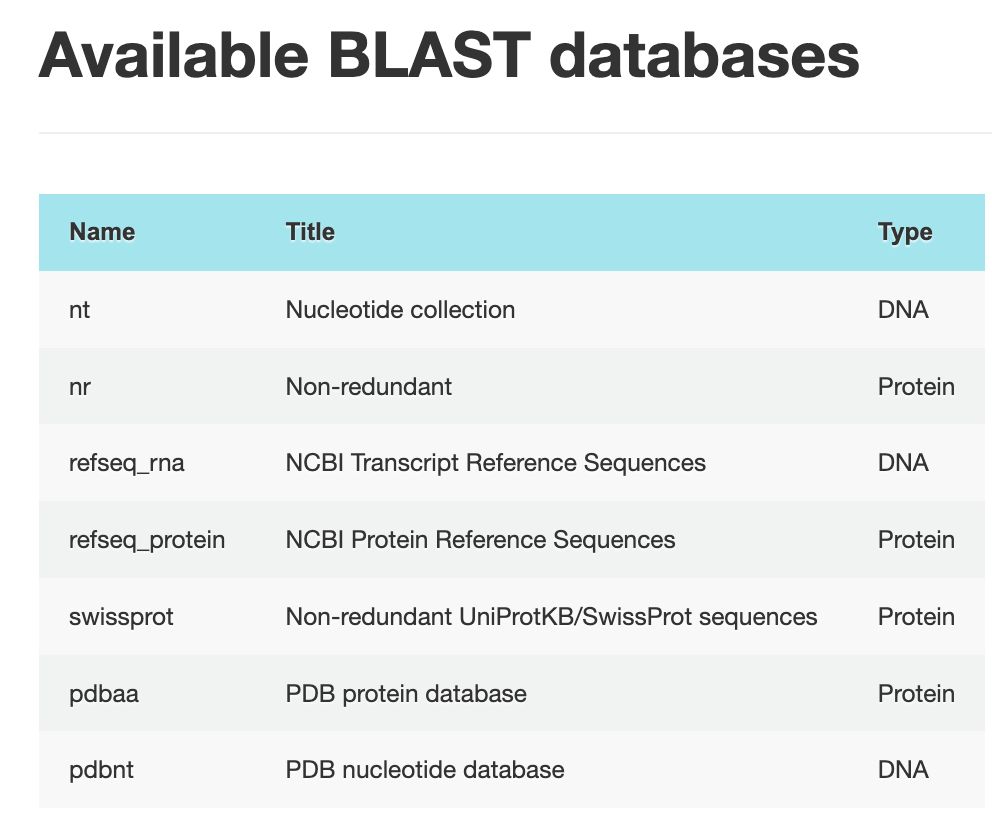

In [ ]:
# Define Ensembl REST API server
server = "https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Put"

# Define type of returned content from REST
content_type = "application/x-www-form-urlencoded"
# content_type = "application/json"

Define search:

In [ ]:
program = "blastn"
database = "nt"
sequence = "TTTGTAGTTACATAGCAAAATGCGCGTTTATTTCGGCTCAGTAAATTAAGAACATTTTCGTTACACGTTGCCACGCCCCCCCATCCAACGGCAAACCACCCCCCGCCTCCGCCTTCAAGACAGAGAGAGAGATAGAATAAAACAGAGAGAGAGCAACAACAACAATATATAACCAAAACGAAAGATTTCCGCAAGAAACCACAAAAAAAAACAACAATTGCTTTGGTTCTGATGATTCTCGTAACAGCAAAAACAACAAGATTTATAATCTAAATCAAAAGAAACTGTGCTCTCCGCTGTGCGTGGCTGTGAGTGCGTTTGTGCGGTACGGTGCGTGCATTATAACAATTATTGCACAAAAGGCATGACAAACGTGGGGCGGGGGTGTCTGTAAATGTGAGTGCGATAGAGCGCGACATATTCAAACAAGCTAGGGACGGAGTAGGTGAGCGAGGGAGAGAGAGAACGCGACGGTGGCAACAACAAAGGGCTGTGATTTTACTTTGCCCCCTCCACCCTGTACCCCGTCCCATCCATACACTTGCGTATTTACCAAATAAACGGAACATACATAAGCCAAAATAGGCAGAACAACAACAACATTAAGAGTCAACTAAACAGCAAATCGAATAGTTTCGTGGGAGAAAGGACAGCGTAGCAGAGTCATTGGAAAACTGGCCGCGTAAGGGAGCGCAATGGATGTCCTGGAAATGCTGCGCGCCAGCGCCAGCGGCAGCTACAACACAATATTCTCGGACGCGTGGTGCCAATATGTCTCCAAGCAGATCACAGCAACGGTAAGTGCACTTCACCCTTTCTTTGTCTTTTTATTTGCTTTGACTTTGGCTTGCTGTTTGTTTGCAATATGAGTGAGTCAGTTGGAAGACAATATGTGCGAGAGCGAGAGGACGCGAGGATTAGAAGGGCAGCTGGAAAGCTTAAAAAAAAATGCGATGCAGGATTACAGCTGTTCGGGCTTGTGTCCGTGCTTAACGCGCGGGAGAGAGAACGTGAGCGAAAAGAGAGCATGTGGATCTTACTTGAGCAGGATAACAGCTGTTTTAGGTTCATGTCCAGGCTACATATAATATAAGATTAATAAGTATTTACGTACTCACGTCACAATTCTTTTATATAATTCAAGAATTTTATTATGAATATAGCTTTTTTTTGTGACAACATCCATAAAGATTAGGTCCCCTGATAAAAATCACAGAATGAGCGATAAAGCAGACCTAAGTAGT"

megablast = True

Submit search:

In [ ]:
# Check if program defined correctly
programs = ["blastn", "blastp", "blastx", "tblastn", "tblastx"]
if program not in programs:
    raise ValueError(
        "Program specified is %s. Expected one of %s"
        % (program, ", ".join(programs))
    )

# Enable megablast if requested
if megablast == True:
    search_query = server + "&PROGRAM=" + program + "&MEGABLAST=on" + "&DATABASE=" + database + "&QUERY=" + sequence
else:
    search_query = server + "&PROGRAM=" + program + "&DATABASE=" + database + "&QUERY=" + sequence
    
# Submit search
r = requests.get(
    search_query, 
    headers={"Content-Type" : content_type}
)

# Raise errors is status code is not 200
if r.status_code == 414:
    raise RuntimeError(f"""
    HTTPS request response status code {r.status_code}.
    Please provide path to fasta file instead of sequence.\n
    """)

if r.status_code != 200 and r.status_code != 414:
    raise RuntimeError(f"HTTPS request response status code {r.status_code}. Please try again.\n")

In [ ]:
soup = BeautifulSoup(r.content, "html.parser")

# Find request ID
RID = soup.find('input', {"id": "rid"})['value']

# Find estimated time to completion
comments = soup.find_all(string=lambda text: isinstance(text, Comment))
result = [i for i in comments if i.startswith('QBlastInfoBegin')][0].split("\n")
RTOE = re.findall('[0-9]+', result[2])[0]

### 2. Wait estimated response time:

In [ ]:
# Wait for search to complete
sys.stderr.write(f"Estimated time to completion: {RTOE} seconds.")
time.sleep(int(RTOE))

### 3. Poll for results every 10 seconds:

In [ ]:
status_query = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD=Get&FORMAT_OBJECT=SearchInfo&RID="

In [ ]:
searching = True

while(searching == True):
    # Sleep for 10 seconds
    time.sleep(10)
    
    # Query for search status
    r_status = requests.get(
        status_query + RID, 
        headers={"Content-Type" : content_type}
    )
    # Raise errors is status code is not 200
    if r_status.status_code != 200:
        raise RuntimeError(f"HTTPS request response status code {r_status.status_code}. Please try again.\n")
    
    # Get search status
    soup_status = BeautifulSoup(r_status.content, "html.parser")
    comments = soup_status.find_all(string=lambda text: isinstance(text, Comment))
    status = [i for i in comments if i.startswith('\n                QBlastInfoBegin')][0].split("\n")[2].split()[0]
        
    if status == "Status=WAITING":
        sys.stderr.write("Searching...\n")
        continue
        
    if status == "Status=FAILED":
        sys.stderr.write(f"Search {RID} failed; please report to blast-help@ncbi.nlm.nih.gov.\n")
        searching = False
    
    if status == "Status=UNKNOWN":
        sys.stderr.write(f"Search {RID} expired.\n")
        searching = False  
        
    if status == "Status=READY":
        sys.stderr.write("Search complete, retrieving results...\n")
        searching = False
        
    else:
        sys.stderr.write(f"""
        Something unexpected happened. \n
        Search {RID} possibly failed; please report to blast-help@ncbi.nlm.nih.gov\n
        or post an issue on Github: https://github.com/lauraluebbert/gget\n
        """)
        
        searching = False

### 4. Retrieve results:

In [ ]:
results_query = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD=Get&FORMAT_TYPE=Text&RID=";

In [ ]:
# Retrieve search results
r_results = requests.get(
    results_query + RID, 
    headers={"Content-Type" : content_type}
)
# Raise errors is status code is not 200
if r_results.status_code != 200:
    raise RuntimeError(f"HTTPS request response status code {r_results.status_code}. Please try again.\n")

In [ ]:
soup = BeautifulSoup(r_results.content, "html.parser")

In [ ]:
soup.find('pre')

____